# Deep Convolutional - Image Colorization Using LAB ColorSpace
Image colorization of grayscale/luminance to LABs green and blue component. Combined with the grayscale creates a RGB Image.

In [15]:
%pip install -q imageio pydot tensorflow-gpu==2.9.3 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io

Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
import keras_tuner as kt
from numpy import asarray
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import imageio.v2 as imageio
import glob
from skimage.color import lab2rgb
import PIL
import PIL.Image

## Import all Modules and Configure GPU

In [17]:
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # Debug only
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# Initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [18]:
tf.__version__


'2.9.1'

### Setup Result Directory

In [19]:
root_dir = "result/stylized_colorizing_lab_color_space"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [20]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size, train_size=0.8):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        #ds = ds.cache(filename='/tmp/StylizedColorizing', name='StylizedColorizing')
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    image_count = len(list(data_test_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_test_dir, image_count))
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab(img):
        image = tf.cast(img, tf.float32)

        lab = tfio.experimental.color.rgb_to_lab(image)
        l = lab[..., 0]

        l = tf.expand_dims(l, axis=-1)
        return tf.cast(tf.concat(l, axis=-1), tf.float32)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float32)
        lab = tfio.experimental.color.rgb_to_lab(image)
        a = lab[..., 1]
        b = lab[..., 2]

        a = tf.expand_dims(a, axis=-1)
        b = tf.expand_dims(b, axis=-1)
        return tf.cast(tf.concat([a, b], axis=-1), tf.float32)

    nrBatches = image_count / batch_size

    # Translate [0,255] -> [-128, 128]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab(normalization_layer(x))))

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = (test_ds.map(lambda x: (preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0))))

    train_ds = tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds))
    
    return configure_for_performance(train_ds, AUTOTUNE, 0)


In [21]:
BATCH_SIZE = 12
IMAGE_SIZE = (256, 256)
EPOCHS = 128

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE, 0.95)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

IMAGE_SIZE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

data-colorize: Found 0 files
Found 1263538 files belonging to 1 classes.
data-colorize: Found 0 files
Found 1263538 files belonging to 1 classes.
Number of batches 105295 of 12 elements


## Augment Data

In [22]:

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

def AgumentFunc(x,y):
    return (trainAug(x), trainAug(y))

# apply augmentation image transformation to prevent overfitting.
trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Split data into train and validation
ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)
#Split data into train and validation
train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
val_ds = val_ds.with_options(options)

## Present DataSet Examples

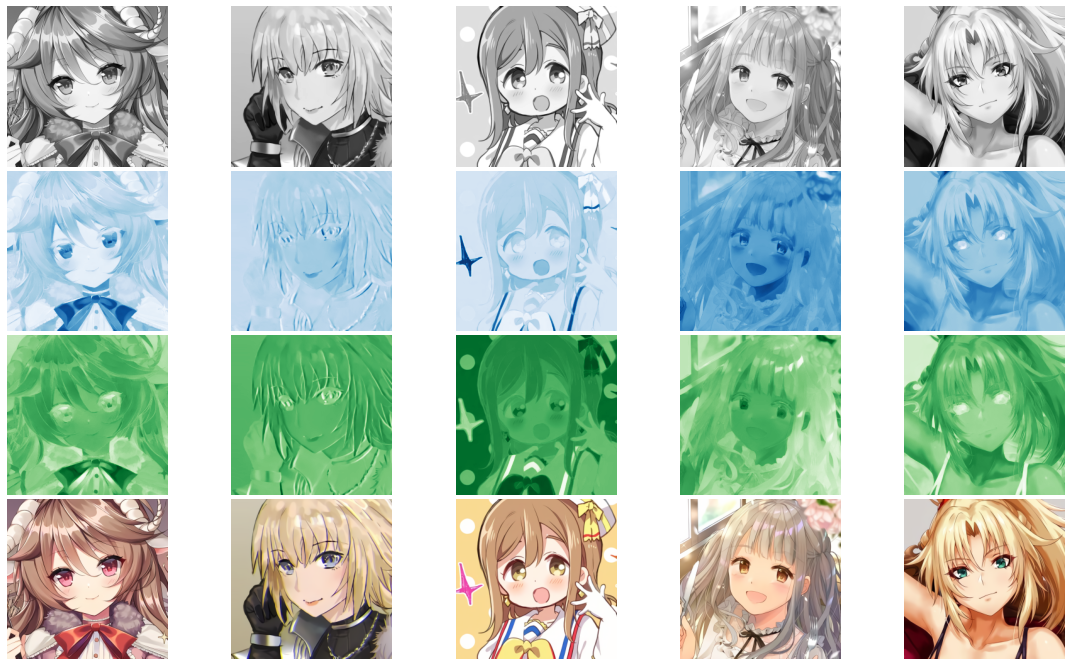

In [23]:

num_examples_to_generate = 9

train_batch_iter = iter(train_images)
train_image_batch, expected_image_batch = next(train_batch_iter)

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for i in range(0, 5):

    trainImage, expectedImage = (train_image_batch[i % len(train_image_batch)], expected_image_batch[i % len(expected_image_batch)])  # (images + 1.0) / 2.0

    #trainImage, expectedImage = images
    # Transform pixel values from [-1,1] to [0,1]
    trainLAB = trainImage[:, :].numpy().astype(dtype='float32')

    ax = plt.subplot(4, nrCol, nrCol * 0 + i + 1)
    plt.imshow(trainLAB, cmap='gray')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 1 + i + 1)
    plt.imshow(expectedImage[:, :, 0], cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(4, nrCol, nrCol * 2 + i + 1)
    plt.imshow(expectedImage[:, :, 1], cmap='Greens')
    plt.axis("off")

    expectedImage = expectedImage[:, :, :].numpy().astype(dtype='float32') * 128
    RGBImage = np.zeros(IMAGE_SIZE)
    RGBImage[:, :, 0] = trainLAB[:, :, 0]
    RGBImage[:, :, 1:] = expectedImage

    rgbExpected = lab2rgb(RGBImage)

    ax = plt.subplot(4, nrCol, nrCol * 3 + i + 1)
    plt.imshow(rgbExpected)
    plt.axis("off")

    if len(train_image_batch) - 1 == i:
        train_image_batch, expected_image_batch = next(train_batch_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Create Model

In [ ]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    number_layer_offset = hp.Int('number_layers', min_value=2, max_value=6, step=1)
    max_layers = 3

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - number_layer_offset, 0)
    num_layers = max(1, min(num_layers, max_layers))

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=4, max_value=8, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

        model.add(layers.Conv2D(filters=filter_size, kernel_size=(3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2))
        model.add(layers.ReLU(dtype='float32'))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.Flatten())
    hp_kernel_filter_size_latent = hp.Int('kernel_filter_latent', min_value=6, max_value=9, step=1)
    model.add(layers.Conv2D(2 ** hp_kernel_filter_size_latent, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))
    model.add(layers.Conv2D(2 ** (hp_kernel_filter_size_latent - 1), (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.ReLU(dtype='float32'))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=9, step=1)

    #upscale_number_layer_offset = hp.Int('upscale_number_layer_offset', min_value=4, max_value=6, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

    model.add(layers.Conv2D(2, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    model.compile(optimizer=hp_optimizer,
                  loss='mse',
                  metrics=['accuracy'])

    return model


## Hyperparameter

In [ ]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def model_builder(hp):
    model = create_model(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=16,
                     factor=5,
                     directory='cache',
                     project_name=str.format('Colorizing - LAB - {0}', "Anime"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_ds.take(1000), epochs=EPOCHS, batch_size=BATCH_SIZE,
            callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], validation_data=train_ds.skip(1000).take(150), verbose=1)
            
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


## Train the Model

In [ ]:
def showResult(model, batchImage, maxNumImages=6):
    output = model.predict(batchImage)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, 4 * 2))
    for image in batchImage:
        for i in range(nrElements):
            trainImage, expectedImage = image

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = expectedImage[i][:, :, :] * 128

            ax = plt.subplot(4, maxNumImages, i + 1)
            plt.imshow((asarray(lab2rgb(canvas)).astype(dtype='float32')))
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 1 + i + 1)
            plt.imshow(output[i, :, :, 0], cmap='Blues')
            plt.axis("off")

            ax = plt.subplot(4, maxNumImages, maxNumImages * 2 + i + 1)
            plt.imshow(output[i, :, :, 1], cmap='Greens')
            plt.axis("off")

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = output[i][:, :, :]

            ax = plt.subplot(4, maxNumImages, maxNumImages * 3 + 1 + i)
            plt.imshow(asarray(lab2rgb(canvas)).astype(dtype='float32'))
            plt.axis("off")

    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData
        self.trainSet = self.trainData.take(1)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainSet)
        fig.savefig("animeColorLAB{0}.png".format(epoch))
        fig = showResult(self.model, self.trainSet, 12)
        fig.savefig("animeColorLABBig{0}.png".format(epoch))


In [ ]:

checkpoint_path = "checkpoints/training_anime_coloring_lab/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

model_history = model.fit(train_images,
                          epochs=EPOCHS,
                          batch_size=1,
                          validation_data=test_images,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])

model.save_weights(checkpoint_path)


Epoch 1/128


2022-08-17 15:08:38.627845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-08-17 15:08:39.122572: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  239/13064 [..............................] - ETA: 33:40 - loss: 0.0185 - accuracy: 0.5880

In [ ]:
model.save("dc-anime-colorization-lab.h5")


: 

# Result

In [ ]:
plt.imshow(PIL.Image.open("animeColorLABBig{0}.png".format(EPOCHS - 1)))
plt.axis("off")
plt.show()


: 

In [ ]:
anim_file = 'anime-colorizing-lab.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('animeColorLABBig*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


: 

In [ ]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    fig = plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    fig.show()
    fig.savefig(title + ".png")


: 

In [ ]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing - LAB ColorSpace"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}.png', "Anime Colorizing - LAB ColorSpace"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)


: 